In [2]:
# This file is aimed to test the 2D Ising model with four body interaction terms using Wolff update method.

# import libraries
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from Configuration import Configuration
import Hamiltonian
from WolffUpdate import WolffUpdate
import itertools

In [3]:
# transfer spins matrix to image 
def config_to_image(spins):
    """Turn a spins array into an image"""
    L = len(spins)
    im = np.zeros([L,L,3])
    for i,j in itertools.product(range(L), repeat=2):
        im[i,j,:] = (1,0,0) if spins[i,j]==1 else (0,0,0)
    return im


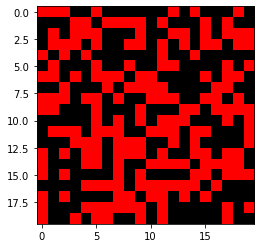

In [4]:
# Show the random configuration
L = 20
J = 1
K = 0.2
T = 2
spins = rnd.choice([-1,1],size = (L, L))
plt.imshow(config_to_image(spins), interpolation='none')


In [4]:
# test configuration file
config = Configuration(spins, L, J, K, T)
print("M =", config.magnetization, " E =", config.energy)

M = 28  E = 6.4


<IPython.core.display.Javascript object>


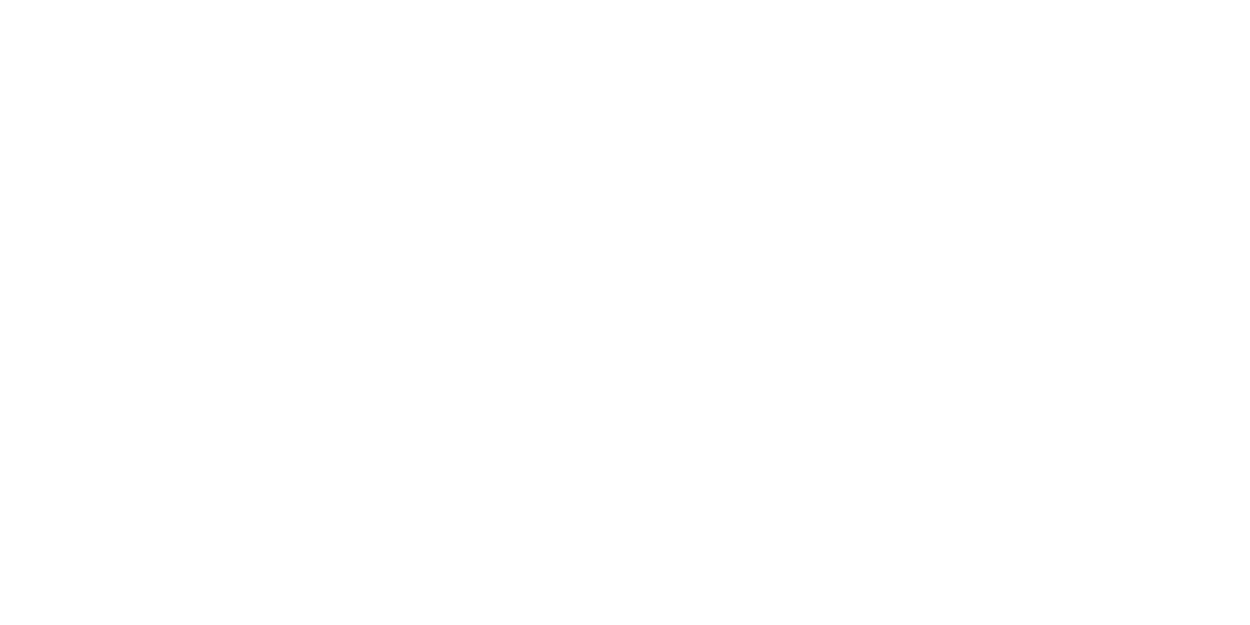

/opt/conda/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


<IPython.core.display.Javascript object>


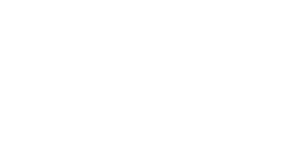

In [11]:
# animation, still debugging




65.1150574684143


(-1.0, 1.0)

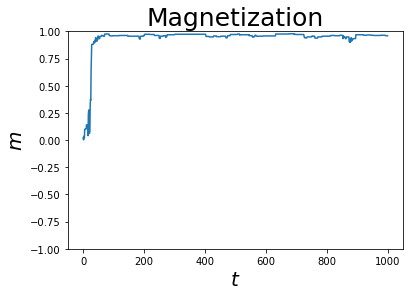

In [5]:
# Magnetization vs Step
L = 30
J = 1
K = 0.2
T = 2

spins = rnd.choice([-1,1],size = (L, L))

import time
t1 = time.time()
n_cycles = 1000


mr = np.zeros(n_cycles)

# Monte Carlo
for n in range(n_cycles):
    update = WolffUpdate(spins, J, K, T)
    spins = update.Wolff_Update_1()
    config = Configuration(spins, L, J, K, T)
    mr[n] = abs(config.magnetization)
mr /= float(L**2)
t2 = time.time()

print(t2-t1)
plt.plot(mr, '-')
plt.title("Magnetization", fontsize=25)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("$m$", fontsize=20)
plt.ylim(-1,1)

In [11]:
# Physical Quantity vs Temp
import time
# This is a production script, it will save the results in files

J = 1
K = 0.2
L = 42
spins = rnd.choice([-1,1],size = (L, L))

# set temperature range
temp_range = np.hstack([np.arange(0.5,2.0,0.5), np.arange(2.0,2.7,0.1), np.arange(2.7,3.3,0.2)])
mag = np.zeros_like(temp_range)
energ = np.zeros_like(temp_range)
chi = np.zeros_like(temp_range)
cv = np.zeros_like(temp_range)

time1 = time.time()
# lattice size
l = [L]
for L in l:
    for i,T in enumerate(temp_range):
    
        av_m, av_m2, av_e, av_e2 = 0,0,0,0

        n_cycles = 100
        n_warmup = 0

        # Monte Carlo
        for n in range(n_warmup+n_cycles):
            update = WolffUpdate(spins, J, K, T)
            spins = update.Wolff_Update_1()
                
            if n >= n_warmup:
                config = Configuration(spins, L, J, K, T)
                av_e  += config.energy
                av_e2 += config.energy**2
                av_m  += config.magnetization
                av_m2 += config.magnetization**2
            
        # normalize averages
        av_m  /= float(n_cycles)
        av_m2 /= float(n_cycles)
        av_e  /= float(n_cycles)
        av_e2 /= float(n_cycles)
            
        # get physical quantities
        fact = 1./L**2
        mag[i] = fact * av_m
        energ[i] = fact * av_e
        cv[i] = fact * (av_e2 - av_e**2) / T**2
        chi[i] = fact * (av_m2 - av_m**2) / T
    
        # print info because progress can be slow
        print("T = %f and %.2f percent done"%(T, (100.*(i+1))/len(temp_range)))


    # save quantities in a file
    np.savetxt("Wolff_update_test_energ_%i.dat"%L, energ)
    np.savetxt("Wolff_update_test_mag_%i.dat"%L, mag)
    np.savetxt("Wolff_update_test_cv_%i.dat"%L, cv)
    np.savetxt("Wolff_update_test_chi_%i.dat"%L, chi)
    
time2 = time.time()
print('time: %i'%(time2-time1))
for L in l:
    energ = np.loadtxt("Wolff_update_test_energ_%i.dat"%L)
    mag = np.loadtxt("Wolff_update_test_mag_%i.dat"%L)
    cv = np.loadtxt("Wolff_update_test_cv_%i.dat"%L)
    chi = np.loadtxt("Wolff_update_test_chi_%i.dat"%L)
    
    fig = plt.figure()
    plt.plot(temp_range, np.loadtxt("Wolff_update_test_energ_%i.dat"%L), '-o', label="energy")
    plt.plot(temp_range, np.abs(np.loadtxt("Wolff_update_test_mag_%i.dat"%L)), '-o', label="magnetization")
    plt.plot(temp_range, np.loadtxt("Wolff_update_test_cv_%i.dat"%L), '-o', label="specific heat")
    plt.plot(temp_range, np.loadtxt("Wolff_update_test_chi_%i.dat"%L)/1000, '-o', label="susceptibility")

#plt.plot([Tc,Tc], [0,1.6], '--', lw=3)
    plt.legend()
    plt.title("Physical quantities", fontsize=25)
    plt.xlabel("$T$", fontsize=20)
    plt.show()

RecursionError: maximum recursion depth exceeded while calling a Python object

In [6]:
# autocorrelation fitting

L = 20
J = 1
K = 0.2
T = 2.5

nt = 300
av_m = 0.0
av_correl = np.zeros([nt])
previous_m = []

n_cycles = 10000
n_warmup = 1000

# Monte Carlo
for n in range(n_cycles + n_warmup + nt):
    
    update = WolffUpdate(spins, J, K, T)
    spins = update.Wolff_Update_1()
            
    if n >= n_warmup:
        config = Configuration(spins, L, J, K, T)
        previous_m.insert(0, config.magnetization)
        #print(previous_m)
        # get rid of furthest previous m
        if n >= n_warmup+nt:
            previous_m.pop()
            #print(previous_m)
            av_m += config.magnetization
            #print(av_m)
            for k in range(nt):
                av_correl[k] += previous_m[k] * config.magnetization
            #print(av_correl)
        
av_m  /= float(n_cycles)
av_correl /= float(n_cycles)


Autocorrelation time = 13.136989427970965


Text(0, 0.5, '$\\mathcal{C}(t)$')

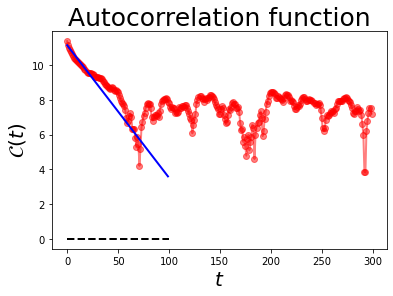

In [7]:
from scipy.optimize import curve_fit

n_fit_pts = 100
xr = np.arange(n_fit_pts, dtype=float)

# fit autocorrelation function
f = lambda x, a, b: a*np.exp(-x/float(b))
a, b = curve_fit(f, xr, (av_correl-av_m**2)[0:n_fit_pts], p0=(1000,1))[0]
print("Autocorrelation time =", b)

plt.plot(np.log(np.abs(av_correl-av_m**2)), '-ro', lw=2, alpha=0.5)

plt.plot(xr, np.log(f(xr, a, b)), 'b-', lw=2)
plt.plot([0,100], [0,0], 'k--', lw=2)

plt.title("Autocorrelation function", fontsize=25)
plt.xlabel("$t$", fontsize=20)
plt.ylabel(r"$\mathcal{C}(t)$", fontsize=20)
#plt.xlim(0, n_fit_pts+10)